---
# Objective

This project will be an open investigation into a dataset. The steps given below outline this project:

1. Explore the NBA datasets available on: basketball-reference.com.
2. Narrow down a few questions and lines of inquiry to pursue in the datasets.
3. Assess the quality of these datasets via exploratory data analysis, placing the results in the context of how the data were generated.
4. Assess the mechanism of missingness for some relevant portion of the dataset.
5. Ask/Answer a question about the dataset using a hypothesis test, being sure to discuss uncertainty of the result and possible shortcomings of the approach.
6. Conclude with ways to improve the work and what data to use to do so.

# NBA Playoffs

This project uses data from `basketball-reference.com` to ask questions about NBA players, who makes it to the playoffs, and how they perform once they get there.

### Getting the data

* The yearly data on all players for the regular season year `20XX` is found at the url:
```
https://www.basketball-reference.com/leagues/NBA_20XX_totals.html
```
* The yearly playoff data on all players in the playoffs for the year `20XX` is found at the url:
```
https://www.basketball-reference.com/playoffs/NBA_20XX_totals.html
```

`pd.read_html` was used to get data from 2012-2018, combine it into a single (cleaned) dataframe, and save it locally.

### Combining playoff and regular season data; cleaning the data; doing descriptive statistics

* For each year, the regular season data and playoff data was joined by player.Since players are sometimes traded mid-season and will occupy more than one row in a given year, this had to be done carefully.
* The data was then cleaned, new columns were created, and null values were handled appropriately. Since each dataset (regular season and playoffs) separately has no "unpredictable" missing values, missingness solely reflected whether a player was present in the playoffs or not. Consider the missingness in a column from the playoffs table and assess its missingness dependent on columns in the regular-season table.
* The data was then assessed through univariate and bivariate analysis, as well as analyzing interesting aggregates.


### Hypothesis Test

Several hypothesis tests were then performed to answer a question prompted by EDA.


---
# Summary of Findings


## Introduction 
The Dataset that we chose to explore was the NBA Playoffs Dataset. This dataset consists of various statistics of NBA players during the league (regular) season and during playoffs from 2012-2018. With this dataset, we wanted to see what factors affected the players going to playoffs and if we could see if there were any correlations with any statistic and their probability of going to the playoffs. 

### Results of Cleaning and EDA:
We first webscraped all the data and put them into dataframes by year and whether they were league or playoffs. We then took all the data and combined them together into one large dataset and distinguished the columns by adding league or playoff to the end of them to know what statistic we were looking at. With that, we discovered some interesting things like having a player for the playoffs but not during the league season (we decided to drop those values because we felt that it did not help answer our question at all) and were also trying to figure out what to do with switching teams. We realized from looking at the data that players that switched teams had a total column and then their separate columns, so we decided to take all the values from the total column and then impute the last team for the team column. 

We then did some exploratory data analysis on this dataset to see how each statistic affects the larger question of will a player go to the playoffs. 

### Results of Missingness:
For our missingess, we knew that all the values were dependent on other columns (there were no values that were Missing Completely at Random), so we ran permutation tests on all the columns to see which statistics affected the missingness the most. The result was that there was a difference in the distributions of players who did and didnt make the playoffs (for each of the statistics we tested). We did 26 permutation tests to check the difference in distributions by player for each statistic. We observed that most of our p-values were 0, so we rejected our null hypothesis and accepted that if one did better in the league, they would then have a higher chance of playing in the playoffs. 

### Results of Hypothesis Test
We decided to do a hypothesis on all the league columns to see if a certain column had any effect on the chance of getting to the playoffs. We did 26 hypothesis tests (all the league columns and we also made an assist turnover rate). With this, 
Null Hypothesis: There is no correlation between assist/turnover rate and making playoffs
Alternative Hypothesis: The higher the percentage/amount played/scored and lower the assist/turnover rate, the more likely that the player is going to the playoffs. 
We decided to use a difference in means statistic to calculate the hypothesis tests with a significance level of 0.01. 

For the procedure, we took each column’s values and sampled it and reassigned it. After that, we grouped by whether they made playoffs or not and then got the shuffled column and took the mean of that and compared it to the observed value. To get the p-value, we calculated the number of times the column was as equal or more extreme than the observed and divided it by the number of simulations we did (we did 1000 simulations for each column). We observed that most of our p-values were 0, so we rejected our null hypothesis and accepted that if one did better in the league, they would then have a higher chance of playing in the playoffs. 

# Introduction and Getting Dataset

In [1]:
%matplotlib inline
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl

# formatting for figures
from IPython.display import display, HTML
CSS = """
.output {
    flex-direction: col;
}
"""
HTML('<style>{}</style>'.format(CSS))

# get rid of warning message
pd.options.mode.chained_assignment = None  

In [ ]:
# Getting the Data:
for i in range(12, 19):
    league = pd.read_html('https://www.basketball-reference.com/leagues/NBA_20{}_totals.html'.format(i))
    pd.concat(league).to_csv('data/league{}.csv'.format(i))
    playoffs = pd.read_html('https://www.basketball-reference.com/playoffs/NBA_20{}_totals.html'.format(i))
    pd.concat(playoffs).to_csv('data/playoffs{}.csv'.format(i))

# Cleaning and EDA:
---

# Cleaning

* In each datafram, every 20 rows there is a row with the column name in it. We designed a function that deleted this row, shifted the indices, and dropped unnecessary columns. See in clear_display()

* As mentioned in the write-up, players are sometimes traded mid-season and will occupy more than one row in a given year. After analyzing the dataset, we noticed that the first occurance of these duplicates contained the running total of stats. However, the first occurance did not have the correct team name listed (just a null value of 'TOT'). So we designed a function to find the most recent team name in the second occurance and replaced 'TOT' with it. See in change_tm()

In [5]:
def clear_display(df):
    return df[df['Player'] != 'Player'].drop(columns=['Unnamed: 0', 'Rk']).reset_index(drop = True)

def change_tm(df):
    duplicate_players = df[df['Player'].duplicated(keep = False)]['Player'].unique()
    for i in duplicate_players:
        player_df = df[df['Player'] == i]
        last_team_loc = list(player_df.index)[0] + 1 # grab the team from the second occurance
        player_df['Tm'] = player_df.loc[last_team_loc, 'Tm']
        keep_row = player_df.iloc[0]
        df.loc[list(player_df.index)[0]] = keep_row
    df = df.drop_duplicates(subset = ['Player'], keep = 'first') # drop the rows from previous teams
    return df

* We decided cleaning the data prior to joining the data would make joining easier. For the 2012-2018 league and playoff datasets, we applied clear_display(). After further research into the data generating process, we decided that chang_tm() only needed to be applied to the league data, since you cannot be traded during playoffs. We them joinded each years league and playoff data on Player. We also decided to add a 'Year' column becuase it would be useful for grouping and aggregating later.  
* It is important to note that there are some players that appear in the league data but not the playoffs (becasue they did not make playoffs) and there are some players with playoff data who do not appear in the league data.

In [ ]:
df_list = []
for i in range(12, 19):
    league = pd.read_csv('data/league{}.csv'.format(i))
    league = clear_display(league)
    league = change_tm(league)

    playoff = pd.read_csv('data/playoffs{}.csv'.format(i))
    playoff = clear_display(playoff)

    comb = pd.merge(league, playoff, on = ['Player'], how = 'outer',  suffixes = ("_league", "_playoff"))
    comb['Year'] = '20{}'.format(i) # add the year
    
    df_list.append(comb)
comb_df = pd.concat(df_list).reset_index(drop=True)
comb_df.to_csv('data/combined.csv')

* We also added a column that determined it the player made the playoffs, which would be useful for grouping and aggregating later. There was also an unecessary 'Unnamed: 0' column that we dropped in addition to duplicate columns of 'Pos', 'Age', 'Tm'.

In [6]:
df = pd.read_csv('data/combined.csv')
df = df.drop(['Unnamed: 0', 'Pos_playoff', 'Age_playoff', 'Tm_playoff'], axis=1).rename(columns={'Pos_league': 'Pos', 'Age_league': 'Age', 'Tm_league': 'Tm'})
playoff_cols = [x for x in list(df.columns) if 'playoff' in x]

def made_playoff(df):
    return ~df[playoff_cols].isnull().apply(lambda x: all(x), axis=1) 
        
df['Made Playoff'] = made_playoff(df)

# Exploratory Data Analysis - "Who Makes the Playoffs"
In this section, we explore the distribution of player satatistics. We focused our investigation on trying to answer the question: "Which stastic (Points, Field Goal %, Total 3 Pointers, etc.) has the biggest influence on a player making the playoffs?"

### Univariate Analysis:
 We first looked at the distributions and statistics of relevant columns separately, using tables and appropriate plots. We looked at age, points, points per game, and minutes played for the league and the playoffs seperately. Althought the league and playoff data is combined into one table, it is still important to analyze them as seperate statistics, rather than just looking at the distribution of the average of each players' Points (for example) over league and playoffs. This reasons for this include but are not limited to: not every player makes the playoffs (i.e. they wont have any playoff statistics), less games are played in playoffs than league (smaller sample size), etc.

The **Age** distribution of players who made playoffs has been normalized to be abe to compare more easily. Without being normalized, the size of the bars would be much smaller becasue of the difference in the sample size (seen in the row count 1961, 1460). Althought the mean value of Age for 'Made Playoff' differs by about 1 year, the shape of the distributions are roughly the same. This indicates there is probably not a significant difference between the ages of players who do and do not make the playoffs.

Made Playoff,False,True
count,1961.000000,1460.000000
mean,25.881183,27.280822
std,4.075769,4.384913
min,19.000000,19.000000
25%,23.000000,24.000000
50%,25.000000,27.000000
75%,28.000000,30.000000
max,41.000000,40.000000


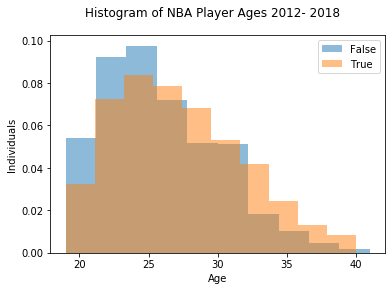

In [7]:
p = pd.DataFrame(df.groupby('Made Playoff')['Age'].describe())
p1 = (df.groupby('Made Playoff')['Age']).hist(grid=False, density=True, alpha=0.5) # normalize the counts
display(p.transpose())

for ax in p1:
    ax.set_xlabel("Age")
    ax.set_ylabel("Individuals")
    
pl.legend([False, True]), pl.suptitle('Histogram of NBA Player Ages 2012- 2018');

The **Total Point** distribution of players who made the playoffs and didnt are both skewed right. In the playoff data, there are a lot of players who did not score very much; whereas in the league data the distribution is more even.

,PTS_league
count,3421.000000
mean,496.990354
std,447.701559
min,0.000000
25%,124.000000
50%,394.000000
75%,766.000000
max,2593.000000


,PTS_playoff
count,1465.000000
mean,79.749488
std,99.976627
min,0.000000
25%,12.000000
50%,48.000000
75%,105.000000
max,748.000000


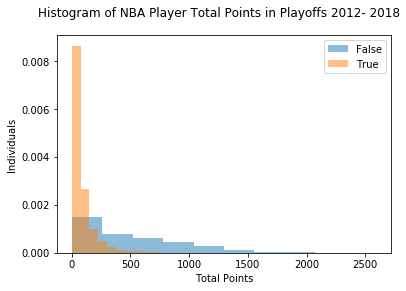

In [8]:
display(pd.DataFrame(df['PTS_league'].describe()))
p1 = df['PTS_league'].hist(density=True, alpha=0.5, grid=False)
display(pd.DataFrame(df['PTS_playoff'].describe()))
p2 = df['PTS_playoff'].hist(density=True, alpha=0.5, grid=False)

p1.set_xlabel("Total Points")
p1.set_ylabel("Individuals")
pl.suptitle('Histogram of NBA Player Total Points in League 2012- 2018')

p2.set_xlabel("Total Points")
p2.set_ylabel("Individuals")
pl.suptitle('Histogram of NBA Player Total Points in Playoffs 2012- 2018')
pl.legend([False, True]);

The **Points per Games Played** distributions and averages are roughly the same for players who did and didnt make playoffs, with a slightly larger peek of low scoring players. You can see the orange is slighlty higer than the blue near the tail and much higher near the '0 Points per Games Played' mark. This could be the result of players who usually played more in league not playing as much (or at all) in playoffs and the players who played a lot of minutes played even more in playoffs.

,PTS/G_league
count,3421.000000
mean,8.151236
std,5.717870
min,0.000000
25%,3.750000
50%,6.795455
75%,11.491228
max,32.012346


,PTS/G_playoff
count,1465.000000
mean,8.079676
std,6.986308
min,0.000000
25%,2.400000
50%,6.400000
75%,12.000000
max,37.400000


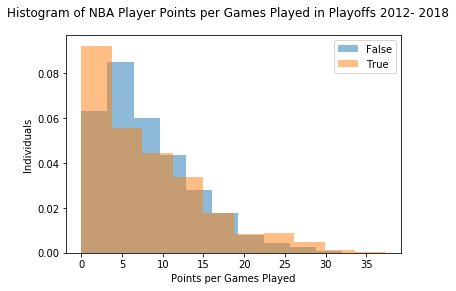

In [22]:
ser1 = (pd.DataFrame((df['PTS_league']/df['G_league']).describe()))
ser1 = ser1.rename(columns={0:'PTS/G_league'})
display(ser1)
p1 = (df['PTS_league']/df['G_league']).hist(density=True, grid=False, alpha=0.5)

ser2=(pd.DataFrame((df['PTS_playoff']/df['G_playoff']).describe()))
ser2 = ser2.rename(columns={0:'PTS/G_playoff'})
display(ser2)
p2 = (df['PTS_playoff']/df['G_playoff']).hist(density=True, grid=False, alpha=0.5)

p1.set_xlabel("Points per Games Played")
p1.set_ylabel("Individuals")
pl.suptitle('Histogram of NBA Player Points per Games Played in League 2012- 2018')

p2.set_xlabel("Points per Games Played")
p2.set_ylabel("Individuals")
pl.suptitle('Histogram of NBA Player Points per Games Played in Playoffs 2012- 2018')
pl.legend([False, True]);

We also decided to look **Total Minutes Played**. The mean of the playoff distribution if much lower than the league. The large spike near 0 on the figure represents a large proportion of players who played very little minutes. These low minutes (and probable lots of 0 minutes) are pulling the average down.

,MP_league
count,3421.000000
mean,1182.975153
std,840.161276
min,0.000000
25%,397.000000
50%,1131.000000
75%,1871.000000
max,3167.000000


,MP_playoff
count,1465.000000
mean,193.606143
std,191.717068
min,0.000000
25%,47.000000
50%,141.000000
75%,263.000000
max,983.000000


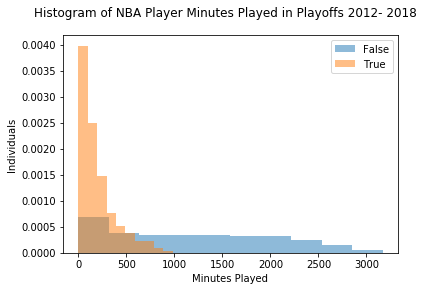

In [23]:
display(pd.DataFrame(data=df['MP_league'].describe()))
p1 = df['MP_league'].hist(density=True, grid=False,  alpha=0.5)
display(pd.DataFrame(df['MP_playoff'].describe()))
p2 = df['MP_playoff'].hist(density=True, grid=False,  alpha=0.5)

p1.set_xlabel("Minutes Played")
p1.set_ylabel("Individuals")
pl.suptitle('Histogram of NBA Player Minutes Played in League 2012- 2018')

p2.set_xlabel("Minutes Played")
p2.set_ylabel("Individuals")
pl.suptitle('Histogram of NBA Player Minutes Played in Playoffs 2012- 2018')
pl.legend([False, True]);

##### Bivariate Analysis: 
We look at the statistics of pairs of columns to identify possible associations. We used pivot tables to get a general feel for the data. They helped us see associations between columns that could make good hypothesis tests and help us answer the question: "Which stastic has the biggest influence on a player making the playoffs?". We also used histograms, scatterplots, line graphs, and box-plots to visualize distributions.

First we looked at a pivot table of the statistics broken down by team.

In [25]:
team_piv = pd.pivot_table(df.drop(columns='Year'), index=['Tm'])
stats_tm = pd.DataFrame(team_piv.describe())
display(stats_tm.iloc[:,0:4])
pd.DataFrame(team_piv.iloc[:,0:4]).head(6)
# tables not fully displayed because there are a lot of teams and stats

,2P%_league,2P%_playoff,2PA_league,2PA_playoff
count,33.000000,31.000000,33.000000,31.000000
mean,0.470225,0.463432,293.502362,41.130664
std,0.017160,0.037493,30.103536,14.795522
min,0.431191,0.375357,182.500000,19.000000
25%,0.460530,0.446870,279.025862,28.993750
50%,0.468811,0.459783,297.660714,38.580645
75%,0.478374,0.479947,310.125000,48.687486
max,0.505369,0.575625,350.920792,76.340000


,2P%_league,2P%_playoff,2PA_league,2PA_playoff
Tm,,,,
ATL,0.477791,0.454208,279.025862,38.972973
BOS,0.480611,0.450000,292.191304,53.065789
BRK,0.470890,0.446711,280.772277,36.804878
CHA,0.431191,0.527333,310.125000,19.000000
CHI,0.454600,0.439627,350.920792,41.803279
CHO,0.457581,0.375357,302.571429,25.125000


We found that the most variation by **Team** was in the Minutes Played (league and playoffs), Total Points (league), Field Goal Attempts (league), and 2 Pointer Atempts (league).

In [26]:
stats_tm.loc['std'].sort_values(ascending=False).head()

MP_league     99.363712
MP_playoff    62.943226
PTS_league    49.290404
FGA_league    37.780837
2PA_league    30.103536
Name: std, dtype: float64

Then we looked at stats by 'Made Playoff'.

In [27]:
# we needed a list of columns cooresponding to the 'league' data because we only cared about the league data
league_list = ['Player', 'Pos', 'Age', 'Tm', 'G_league', 'GS_league', 'MP_league', 'FG_league', 'FGA_league',
 'FG%_league','3P_league', '3PA_league', '3P%_league', '2P_league', '2PA_league', '2P%_league', 'eFG%_league',
 'FT_league', 'FTA_league', 'FT%_league', 'ORB_league', 'DRB_league', 'TRB_league', 'AST_league', 'STL_league',
 'BLK_league', 'TOV_league', 'PF_league', 'PTS_league', 'Year', 'Made Playoff']

In [28]:
playoff_piv = pd.pivot_table(df[league_list].drop(columns='Year'), index=['Made Playoff'])
stats_playoffs = pd.DataFrame(playoff_piv.describe())
display(stats_playoffs.iloc[:,0:6])
playoff_piv.transpose().head(8)

,2P%_league,2PA_league,2P_league,3P%_league,3PA_league,3P_league
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.474317,302.987850,149.239370,0.293708,117.831493,42.129299
std,0.021608,69.611020,38.352812,0.015569,35.407665,14.035802
min,0.459038,253.765426,122.119837,0.282700,92.794493,32.204488
25%,0.466677,278.376638,135.679604,0.288204,105.312993,37.166893
50%,0.474317,302.987850,149.239370,0.293708,117.831493,42.129299
75%,0.481957,327.599062,162.799137,0.299213,130.349993,47.091704
max,0.489596,352.210274,176.358904,0.304717,142.868493,52.054110


Made Playoff,False,True
2P%_league,0.459038,0.489596
2PA_league,253.765426,352.210274
2P_league,122.119837,176.358904
3P%_league,0.282700,0.304717
3PA_league,92.794493,142.868493
3P_league,32.204488,52.054110
AST_league,88.931158,135.300685
Age,25.881183,27.280822


We found that the most variation by **Made Playoffs** was in Minutes Played, Total Points (league), Field Goal Attempts (league), 2 Pointer Attempts (league), and Total Rebounds (league).

In [29]:
stats_playoffs.loc['std'].sort_values(ascending=False).head()

MP_league     306.023801
PTS_league    143.142102
FGA_league    105.018685
2PA_league     69.611020
TRB_league     55.513493
Name: std, dtype: float64

Then we decided to look at a combination of statistics. We looked at the distribution of Made Playoff by Assist/ Tournover Ratio (i.e. how many assists per one tournover). We discovered here that we need to do a little more data cleaning becasue of how the data generating process worked. If a player had 0 tournovers, the pandas made the default value the assist/tournover ratio as np.inf. So we had to  manually replace it with the correct value, which is the number of assists.

On the box plots, the 0 represents playes who didnt make the playoffs and the 1 represents players who did. Both plots have a larger upper whisker than lower indicating there were more larger values than smaller ones. This is reinforced in the large number of outliers that lie above the upper whisker. The similar whisker size on both plots, the interquartile range, represents the similar spread in the data. Overall, the assist to tournover ratio seems to not be significantly different.

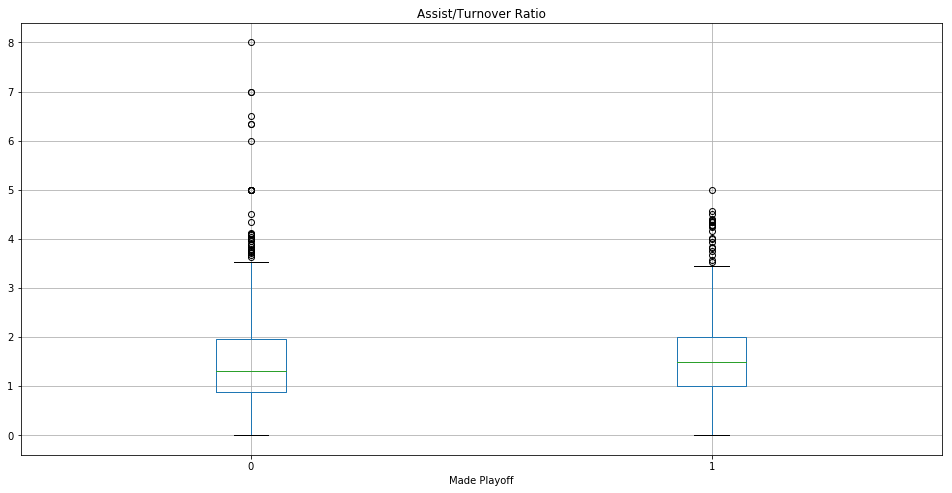

In [30]:
league_df = df[league_list]
league_df['Assist/Turnover Ratio'] = league_df['AST_league'] / league_df['TOV_league']

def clean_ratio(x):
    if x['Assist/Turnover Ratio'] is np.inf:  # clean the np.inf values
        return x['AST_league']
    else:
        return x['Assist/Turnover Ratio']

league_df['Assist/Turnover Ratio'] = league_df.apply(lambda x: clean_ratio(x), axis=1)
league_df = league_df.replace({True:1, False:0})

fig = league_df.boxplot(column=['Assist/Turnover Ratio'], by='Made Playoff', figsize=(16,8)).get_figure()
fig.suptitle('');

Similarily, in the distribution of Made Playoff by **Total Points**, both plots have a [much] larger upper whisker than lower indicating there were [many] more larger values than smaller ones. Additionally, there are also a large number of outliers that lie above the upper whiskers. The interquartile range of the Total Points with players who did make the playoffs is larger than that of the players who did not. This represents the the Total Points of players who made the playoffs being more spread (reinforced by the greater number of outliers above the upper whisker). It is intesting to note the average Total Points is greater for players who made the playoffs. This may be evidence of a good statistic for predicting playoffs.

Made Playoff,0,1
count,1961.000000,1460.000000
mean,410.596634,613.030137
std,402.885207,477.784218
min,0.000000,0.000000
25%,69.000000,235.000000
50%,284.000000,520.000000
75%,656.000000,878.250000
max,2133.000000,2593.000000


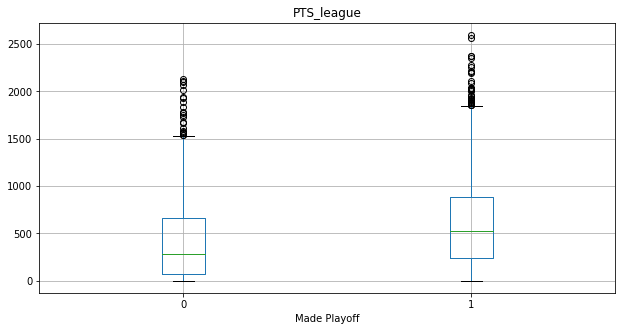

In [31]:
display(pd.DataFrame(league_df.groupby(['Made Playoff'])['PTS_league'].describe()).transpose())
fig = league_df.boxplot(column=['PTS_league'], by='Made Playoff', figsize=(10, 5)).get_figure()
fig.suptitle('');

We then did the same thing for the distribution of Made Playoff by **Total 3 Pointers**. The interquartile range of the Total 3 Pointers with players who did make the playoffs is also larger than that of the players who did not. This represents the the Total 3 Pointers of players who made the playoffs being more spread (reinforced by the greater number of outliers above the upper whisker). Total 3 Pointers is greater for players who made the playoffs and may also be a good statistic for predicting playoffs.

Made Playoff,0,1
count,1961.000000,1460.000000
mean,32.204488,52.054110
std,42.949632,58.236529
min,0.000000,0.000000
25%,0.000000,2.000000
50%,11.000000,33.000000
75%,51.000000,84.000000
max,240.000000,402.000000


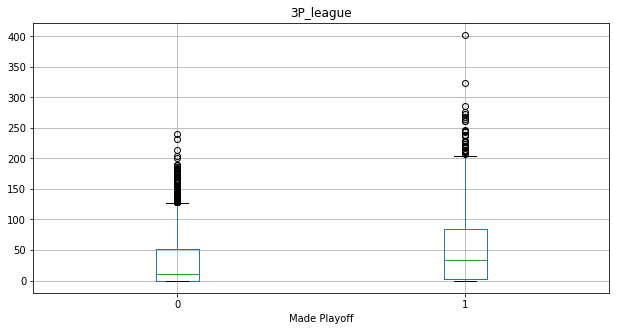

In [32]:
display(pd.DataFrame(league_df.groupby(['Made Playoff'])['3P_league'].describe()).transpose())

fig = league_df.boxplot(column=['3P_league'], by='Made Playoff', figsize=(10, 5)).get_figure()
fig.suptitle('');

Similarily, with the distribution of Made Playoff by **Age**, the ages for players who made the playoffs was more spread. All these statistics appear to be higer in playoffs, but which one is a better predictor?

Made Playoff,0,1
count,1961.000000,1460.000000
mean,25.881183,27.280822
std,4.075769,4.384913
min,19.000000,19.000000
25%,23.000000,24.000000
50%,25.000000,27.000000
75%,28.000000,30.000000
max,41.000000,40.000000


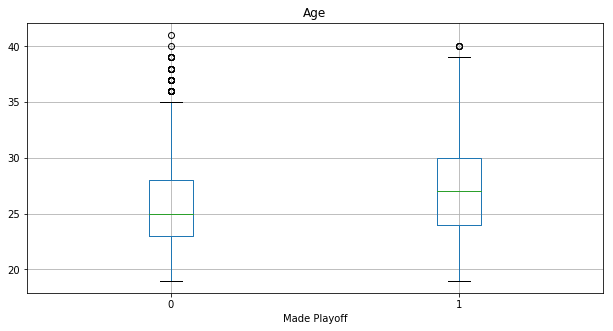

In [33]:
display(pd.DataFrame(league_df.groupby(['Made Playoff'])['Age'].describe()).transpose())


fig = league_df.boxplot(column=['Age'], by='Made Playoff', figsize=(10, 5)).get_figure()
fig.suptitle('');

### Interesting Aggregates
We choose columns to group-by and examined their aggregate statistics. We knew that Total Points, Age, amd several other statistics seemed to have some kind of correlation with making playoffs. But we wanted to explore aggregating the data by the non- statistical columns. We decided to look grouping ny 'Year' and 'Team' and examining that effect of the Total Points.

This figure shows that the years all follow a similiar distribution, roughly normal.

,count,mean,std,min,25%,50%,75%,max
Year,,,,,,,,
2012,478.0,398.732218,353.250707,0.0,106.00,304.0,614.75,1850.0
2013,468.0,515.371795,447.911182,0.0,141.50,396.5,810.50,2280.0
2014,481.0,516.582121,470.422228,0.0,115.00,401.0,821.00,2593.0
2015,492.0,500.071138,422.431191,0.0,141.00,420.5,772.00,2217.0
2016,476.0,530.613445,457.296571,0.0,144.75,435.0,799.00,2376.0
2017,486.0,534.471193,487.642042,0.0,143.00,434.5,772.75,2558.0
2018,540.0,484.407407,466.914727,0.0,82.00,363.0,773.50,2251.0


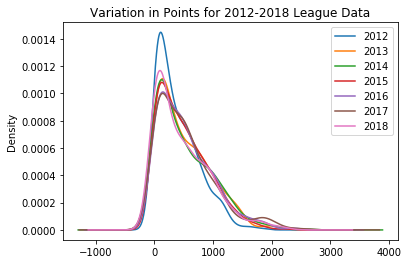

In [34]:
display(pd.DataFrame(df.groupby(['Year'])['PTS_league'].describe()))
title='Variation in Points for 2012-2018 League Data'

(
    df
    .groupby(['Year'])['PTS_league']
    .plot(kind='kde', legend=True, subplots=False, title=title)
); 

Overall, the variation of **Total Points by Team** in League was small with a few exceptions.

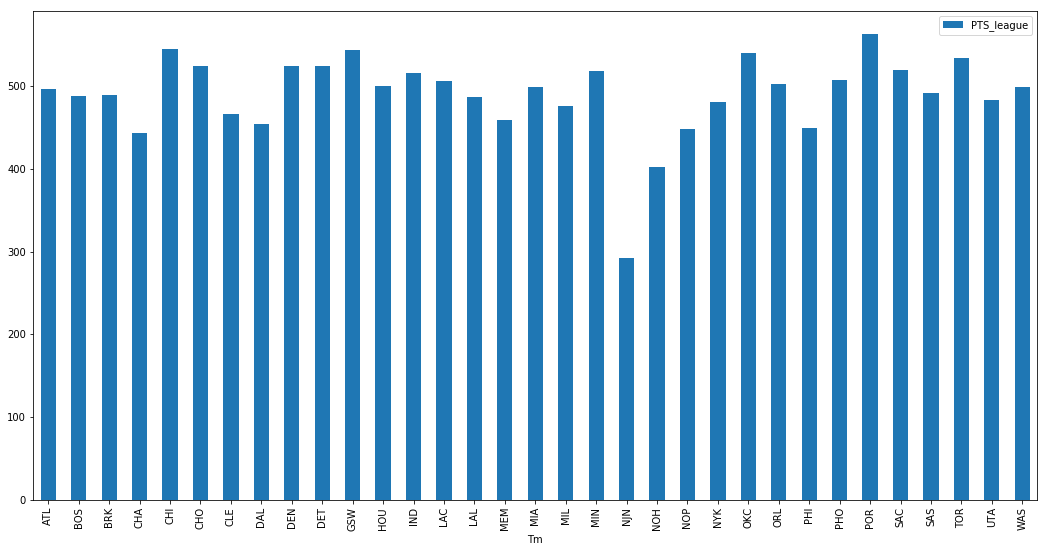

In [35]:
age = df.groupby('Tm')['PTS_league'].mean().to_frame()
age.plot.bar(figsize=(18,9));

We then decided to look at the variation in **Total Points** of League vs. Playoffs by Team. The playoff total points is much smaller (because less games are played), but it seems to follow the same trend as leage total points.

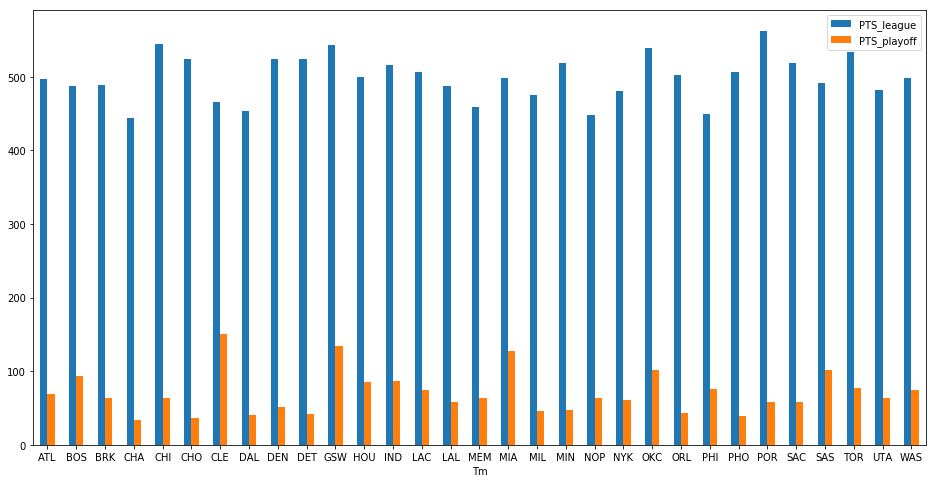

In [36]:
both_points = df.groupby('Tm')[['PTS_league', 'PTS_playoff']].mean()
df2 = pd.DataFrame({'PTS_league': both_points.PTS_league, 'PTS_playoff': both_points.PTS_playoff}, index=both_points.index)
df2 = df2.dropna()
df2.plot.bar(rot=0, figsize=(16,8));

### Missingness Assessment
Since each dataset (regular season and playoffs) separately has no "unpredictable" missing values, missingness will solely reflect whether a player was present in the playoffs or not. Consider the missingness in a column from the playoffs table and assess its missingness dependent on columns in the regular-season table.

To assess the missingness, i.e. what players made the playoffs, we decided to do a permutations on all the league columns to see if there was a difference in the null and not null distributions. We did 26 permutation tests (all the league columns and we also made an assist turnover rate). Our Null Hypothesis was: There is no correlation between the specific statistic and making playoffs. The Alternative Hypothesis was: The better the specific statistic, the more likely that the player would make it to playoffs. We decided to use a difference in means statistic to calculate the permutation tests with a significance level of 0.01. 

For the procedure, we took each column’s values and sampled it and reassigned it. After that, we grouped by whether they made playoffs or not and then got the shuffled column and took the mean of that and compared it to the observed value. To get the p-value, we calculated the number of times the column was as equal or more extreme than the observed and divided it by the number of simulations we did (we did 1000 simulations for each column). At the end, we realized that most of our p-values were 0, so we rejected our null hypothesis and accepted that if  player had better league statistics (the ones we tested), they would then have a higher chance of making the playoffs.

In [83]:
obs_vals_p = [] # keep track of values for dataframe of findings at the end
p_vals_p = []
obs_vals_h = []
p_vals_h = []

In [84]:
# Helper functions for testing
def permutation_test(data, col, group_col, test_statistic, N=1000):
    """
    Return the distribution of permuted statistics and the observed statistic
    resulting from a permutation test.

    :param: data: DataFrame of data observations and the labels for two groups.
    :param: col: Column name for the column containing the data.
    :param: group_col: Column name for the column contain the labels for the two groups.
    :param: test_statistic: The test statistic to apply to the groups (a function).
    :param: N: The number of times N to run the permutation test.
    """

    # get the observed test statistic
    obs = test_statistic(data, col, group_col)

    # run the permutations
    shuffled_stats = []
    for _ in range(N):
        
        shuffled = data[group_col].sample(frac=1, replace=False).reset_index(drop=True)
        with_shuffled = data[[col]].assign(shuffled=shuffled)
        shuffled_stat = test_statistic(with_shuffled, col, 'shuffled')
        shuffled_stats.append(shuffled_stat)

    shuffled_stats = np.array(shuffled_stats)
    p_val = np.count_nonzero(shuffled_stats >= obs) / N

    obs_vals_p.append(str(obs))
    p_vals_p.append(str(p_val))
    return [pd.Series(shuffled_stats), obs]

def hyp_test(data, col, group, N=1000):
    obs = abs(data.groupby(group)[col].mean().diff()[1])

    avg_diffs = []
    for _ in range(N):
        # shuffle the weights
        shuffled_rates = (data[col].sample(replace=False, frac=1).reset_index(drop = True))
        # put them in a table
        shuffled = (data.assign(**{'Shuffled {}'.format(col): shuffled_rates}))
        # compute the group differences (test statistic!)
        difference = (shuffled.groupby(group)['Shuffled {}'.format(col)].mean().diff()[1])
        avg_diffs.append(difference)
    p_val = np.count_nonzero(avg_diffs >= obs) / N
    obs_vals_h.append(str(obs))
    p_vals_h.append(str(p_val))

    return [pd.Series(avg_diffs), obs]

def diff_in_means(data, col, group_col):
    """difference in means"""
    return data.groupby(group_col)[col].mean().diff().iloc[-1]

Reload clean DataFrame with necessary columns.

In [85]:
df = pd.read_csv('data/combined.csv')
df = df.drop(['Unnamed: 0'], axis=1)
playoff_cols = [x for x in list(df.columns) if 'playoff' in x]
def made_playoff(df):
    return ~df[playoff_cols].isnull().apply(lambda x: all(x), axis=1) 
df['Made Playoff'] = made_playoff(df).replace({True:1, False:0})

#All the Columns we're testing (and Assist/Turnover Rate)
stats = [col for col in df.columns if 'league' in col]
stats = [stats[1]] + stats[3:] # columns we cant aggregate 
stats.append('Made Playoff')
hypothesis_test = df[stats]
#Replace to 0s to 0.01 so that we do not get infinity or a divide by zero error for assist/turnover rate
hypothesis_test['TOV_league'] = hypothesis_test['TOV_league'].replace(0, 0.01) 
#Add column to see assist/turnover rate
hypothesis_test['AST_TOV_Rate'] = hypothesis_test['AST_league'] / hypothesis_test['TOV_league']
stats.append('AST_TOV_Rate')
stats = stats[:-2] + [stats[-1]]

Plotting the Permutation Tests

In [86]:
p_tests = []
for stat in stats:
    p_test = permutation_test(hypothesis_test, stat, 'Made Playoff', diff_in_means, 1000)
    p_tests.append(p_test)

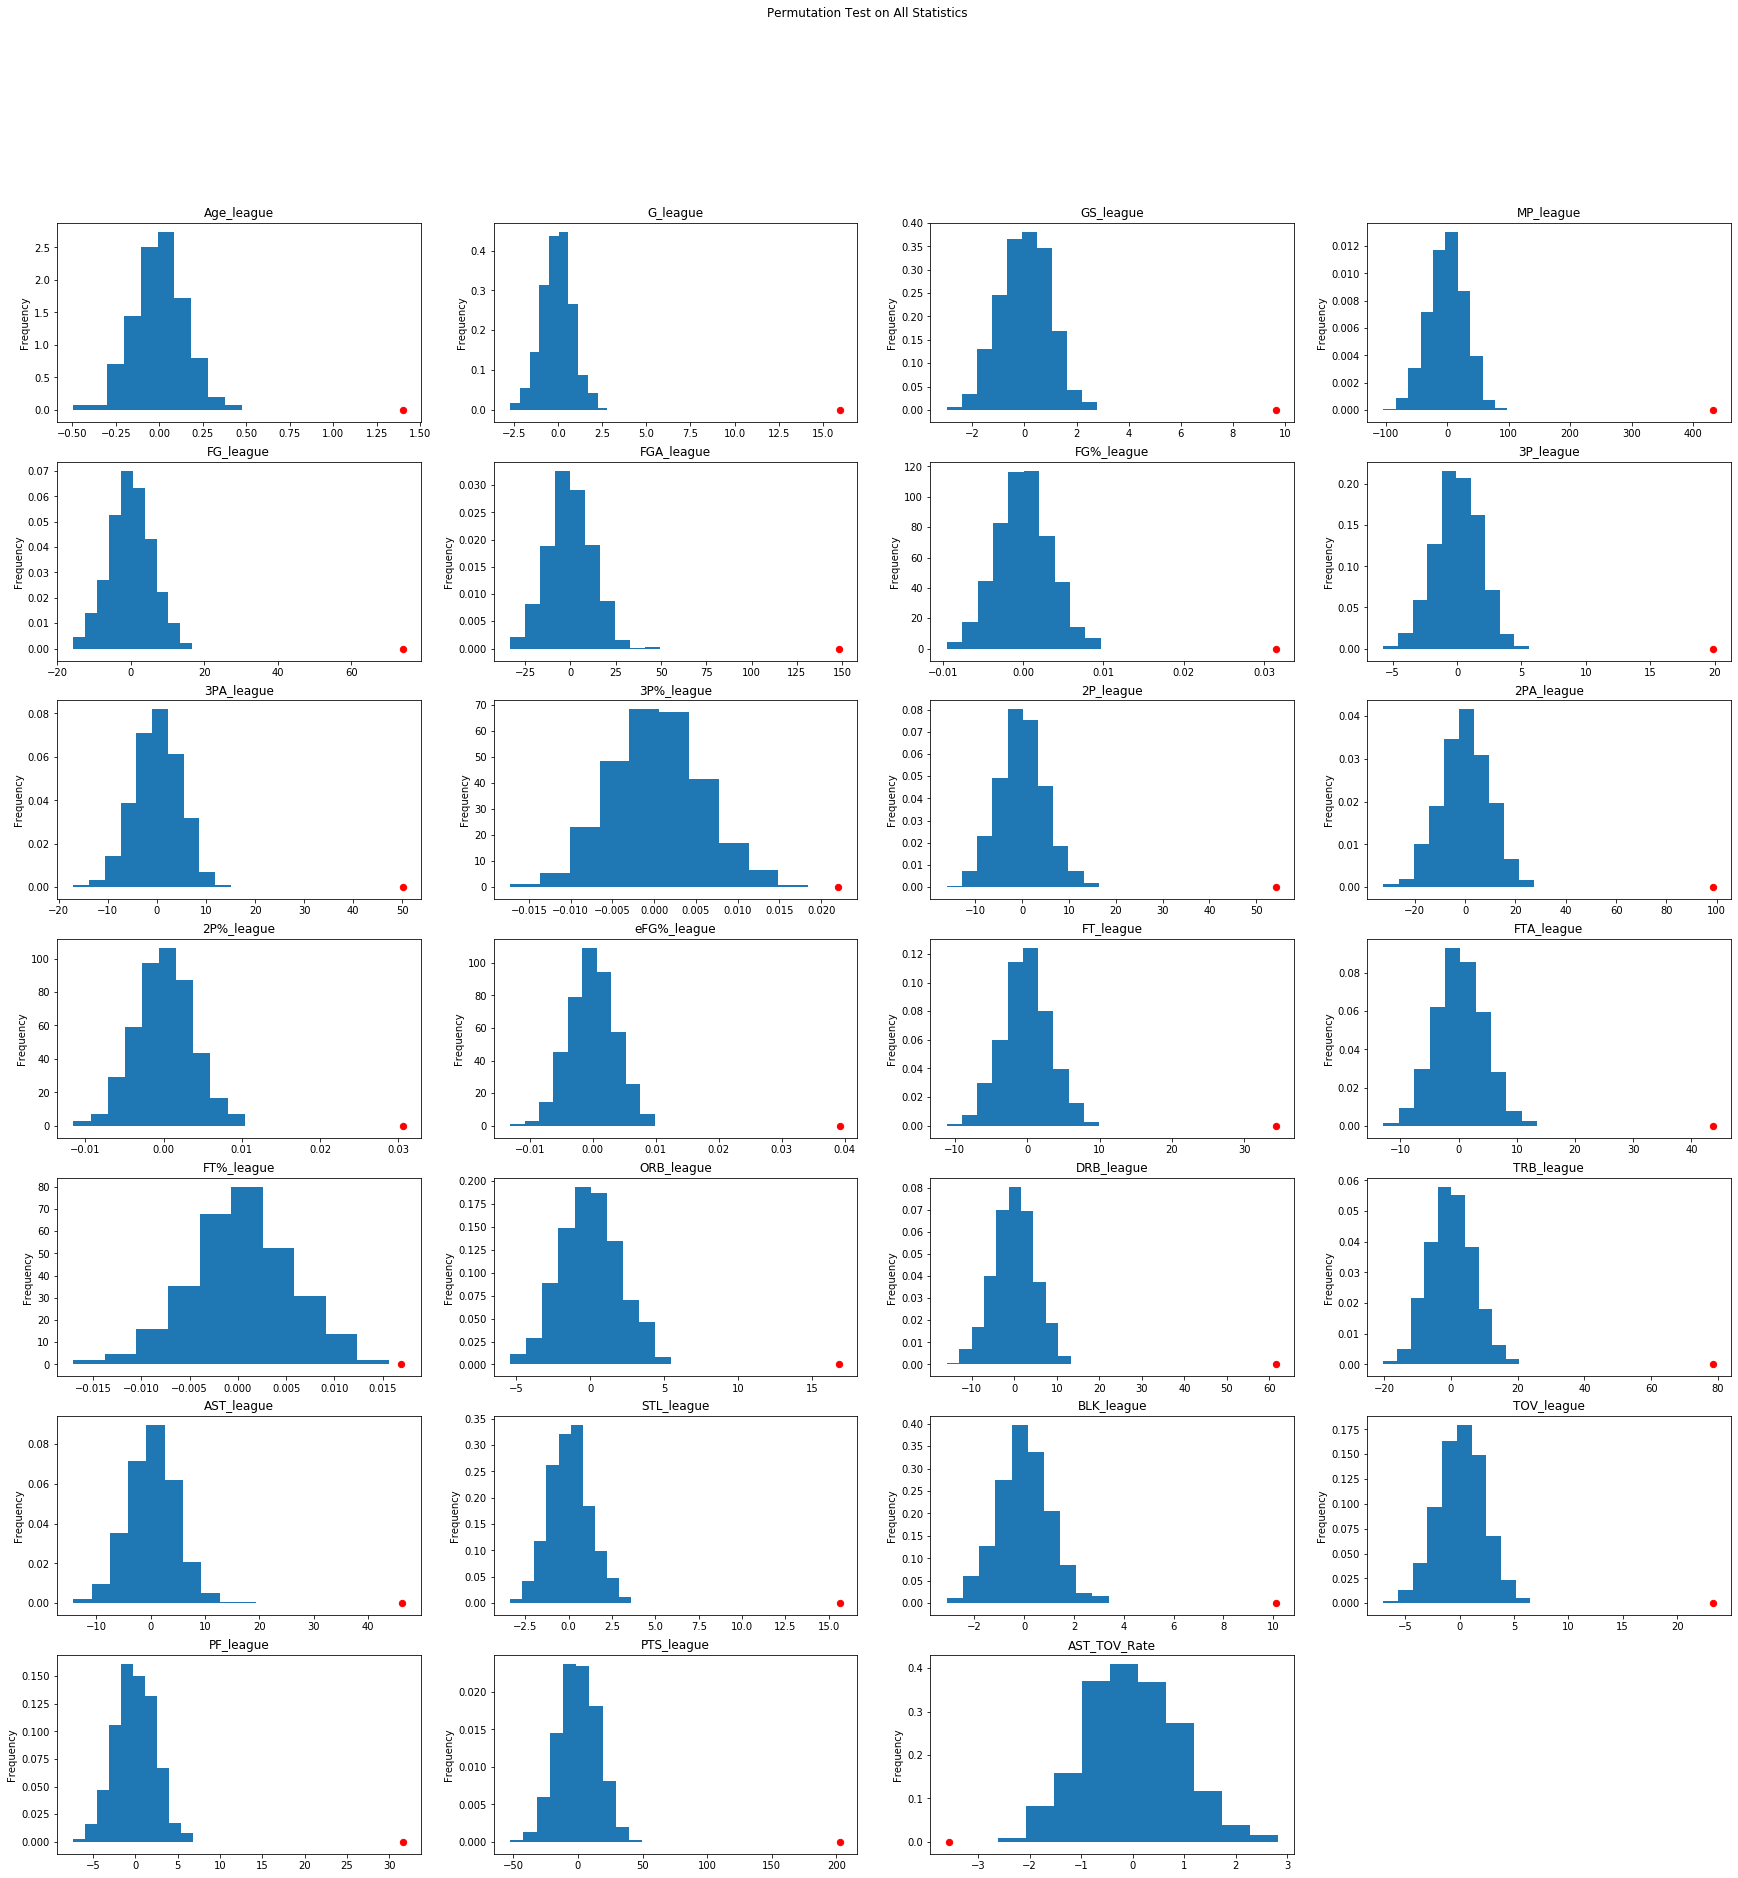

In [87]:
fig, axes = plt.subplots(7, 4, figsize=(30,30))
k = 0
for i in range(len(stats)):
    x_idx = k // 4
    y_idx = k % 4 # keeping track of which subplot youre adding too
    title = stat
    p_tests[i][0].plot(kind='hist', density=True, ax=axes[x_idx, y_idx], title=stats[i]).scatter(p_tests[i][1], 0, color='red', s=40)
    k += 1
    
fig.suptitle('Permutation Test on All Statistics')
axes.flat[-1].set_visible(False);

# Hypothesis Testing

Hypothesis Test Description:

We decided to do a hypothesis on all the league columns to see if a certain column had any effect on the chance of getting to the playoffs. We did 26 hypothesis tests (all the league columns and we also made an assist turnover rate). Our Null Hypothesis was: There is no correlation between assist/turnover rate and making playoffs. The Alternative Hypothesis was: The higher the percentage/amount played/scored and lower the assist/turnover rate, the more likely that the player is going to the playoffs. We decided to use a difference in means statistic to calculate the hypothesis tests with a significance level of 0.01. 

For the procedure, we took each column’s values and sampled it and reassigned it. After that, we grouped by whether they made playoffs or not and then got the shuffled column and took the mean of that and compared it to the observed value. To get the p-value, we calculated the number of times the column was as equal or more extreme than the observed and divided it by the number of simulations we did (we did 1000 simulations for each column). At the end, we realized that most of our p-values were 0, so we rejected our null hypothesis and accepted that if player had better league statistics (the ones we tested), they would then have a higher chance of making the playoffs.

In [88]:
h_tests = []
for stat in stats:
    h_test = hyp_test(hypothesis_test, stat, 'Made Playoff', 1000) 
    h_tests.append(h_test)

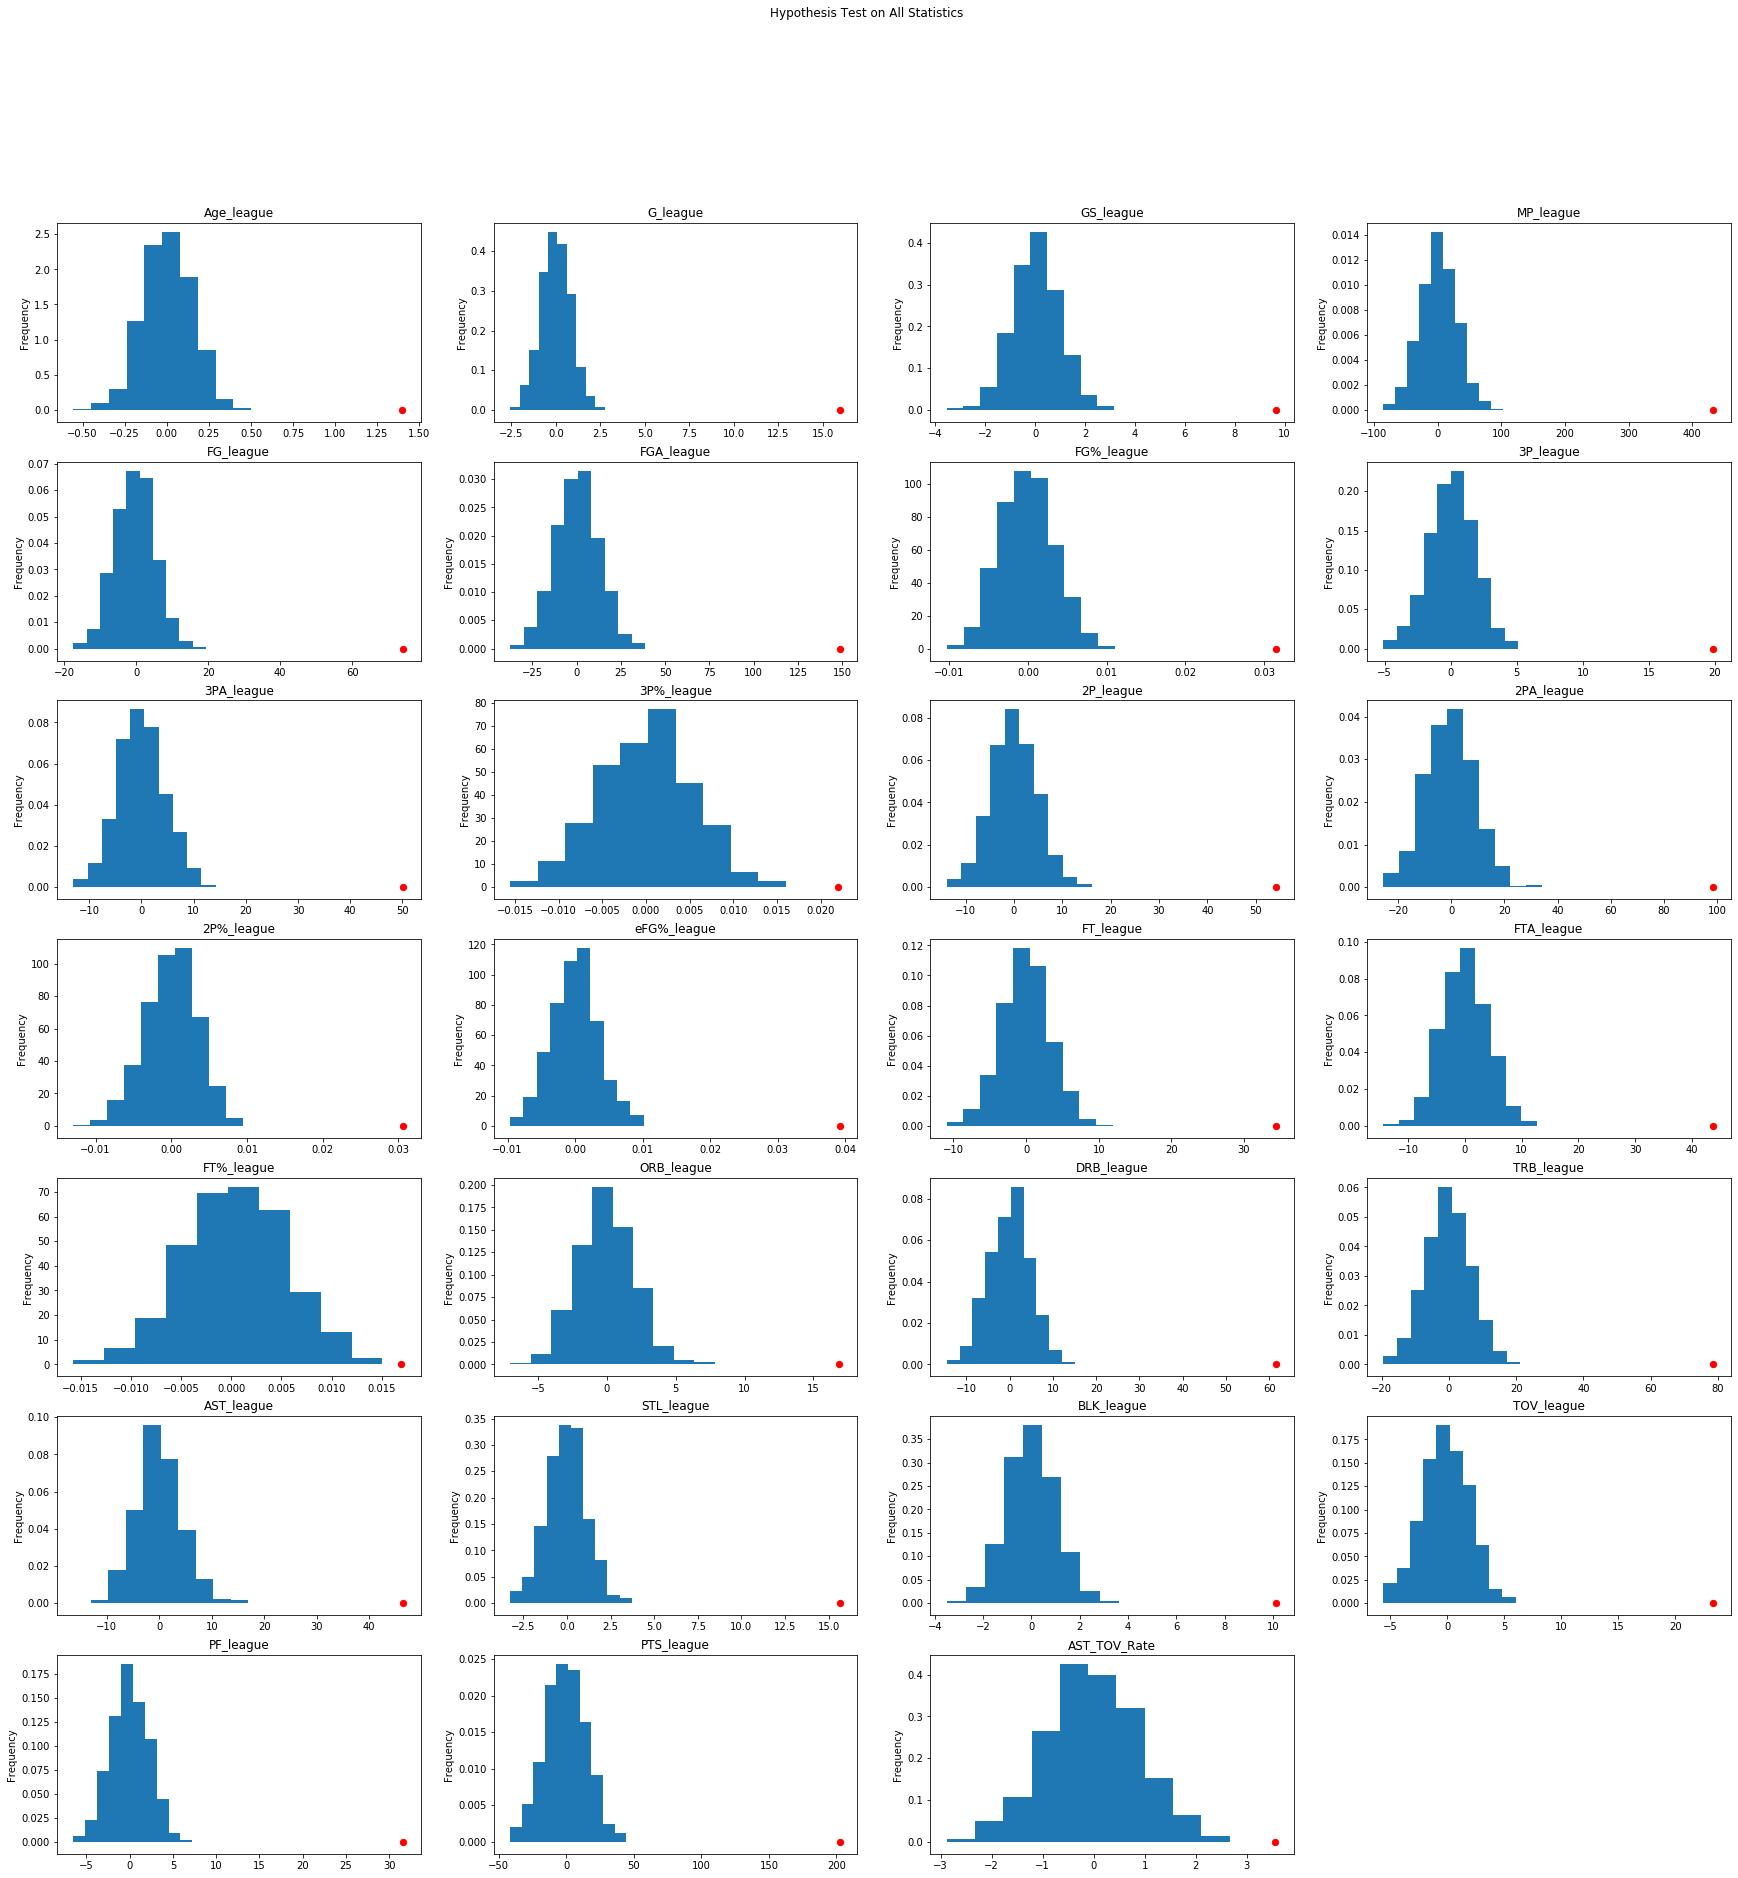

In [89]:
fig, axes = plt.subplots(7, 4, figsize=(30,30))
k = 0
for i in range(len(stats)):
    x_idx = k // 4
    y_idx = k % 4 # keeping track of which subplot youre adding too
    title = stat
    h_tests[i][0].plot(kind='hist', density=True, ax=axes[x_idx, y_idx], title=stats[i]).scatter(h_tests[i][1], 0, color='red', s=40)
    k += 1
    
fig.suptitle('Hypothesis Test on All Statistics')
axes.flat[-1].set_visible(False);

Below we have the Observed Values of each Permutation adn Hypothesis Test as well as the p values. As you can see, for every statistic we rejected the Null Hypothesis; with the exception of the permutation test of assits/tournover ratio. This means that overall, players with higher legue statistics are more likely to make the playoffs.

In [91]:
pd.DataFrame({'Observed Values: Permutation Tests': obs_vals_p, 'P Values: Permutation Tests:': p_vals_p, 'Observed Values: Hypothesis Tests': obs_vals_h, 'P Values: Hypothesis Tests:': p_vals_h}, index=stats)

,Observed Values: Permutation Tests,P Values: Permutation Tests:,Observed Values: Hypothesis Tests,P Values: Hypothesis Tests:
Age_league,1.3996388479459014,0.0,1.3996388479459014,0.0
G_league,15.974385098461084,0.0,15.974385098461084,0.0
GS_league,9.657142707452863,0.0,9.657142707452863,0.0
MP_league,432.7830094374551,0.0,432.7830094374551,0.0
FG_league,74.0886893743058,0.0,74.0886893743058,0.0
FGA_league,148.51884871431264,0.0,148.51884871431264,0.0
FG%_league,0.0315158236740426,0.0,0.0315158236740426,0.0
3P_league,19.849622082666798,0.0,19.849622082666798,0.0
3PA_league,50.07400054487158,0.0,50.07400054487158,0.0
3P%_league,0.02201765435420633,0.0,0.02201765435420633,0.0
